### Credit Card Lead Prediction
Happy Customer Bank is a mid-sized private bank that deals in all kinds of banking products, like Savings accounts, Current accounts, investment products, credit products, among other offerings.



The bank also cross-sells products to its existing customers and to do so they use different kinds of communication like tele-calling, e-mails, recommendations on net banking, mobile banking, etc. 



In this case, the Happy Customer Bank wants to cross sell its credit cards to its existing customers. The bank has identified a set of customers that are eligible for taking these credit cards.



Now, the bank is looking for your help in identifying customers that could show higher intent towards a recommended credit card, given:

Customer details (gender, age, region etc.)
Details of his/her relationship with the bank (Channel_Code,Vintage, 'Avg_Asset_Value etc.)

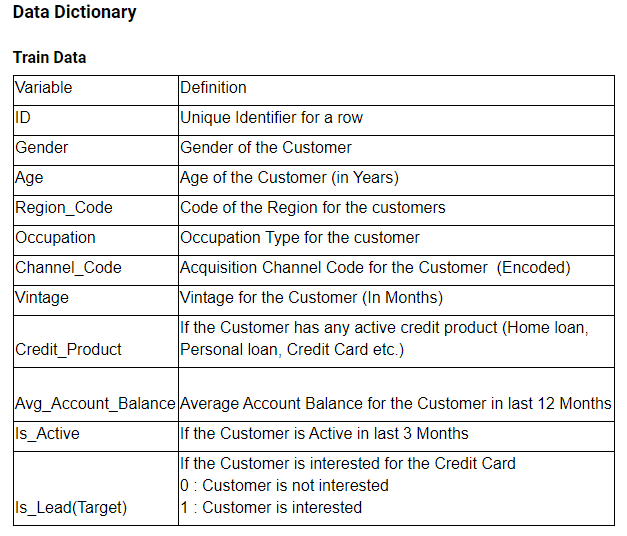

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# To supress all the warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
from google.colab import files
upload = files.upload()

Saving train_s3TEQDk.csv to train_s3TEQDk.csv


In [4]:
# Reading the training data
import io
original_data = pd.read_csv(io.BytesIO(upload['train_s3TEQDk.csv']))

In [5]:
original_data.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


In [6]:
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   245725 non-null  object
 1   Gender               245725 non-null  object
 2   Age                  245725 non-null  int64 
 3   Region_Code          245725 non-null  object
 4   Occupation           245725 non-null  object
 5   Channel_Code         245725 non-null  object
 6   Vintage              245725 non-null  int64 
 7   Credit_Product       216400 non-null  object
 8   Avg_Account_Balance  245725 non-null  int64 
 9   Is_Active            245725 non-null  object
 10  Is_Lead              245725 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 20.6+ MB


In [7]:
original_data.describe()

,Age,Vintage,Avg_Account_Balance,Is_Lead
count,245725.000000,245725.000000,2.457250e+05,245725.000000
mean,43.856307,46.959141,1.128403e+06,0.237208
std,14.828672,32.353136,8.529364e+05,0.425372
min,23.000000,7.000000,2.079000e+04,0.000000
25%,30.000000,20.000000,6.043100e+05,0.000000
50%,43.000000,32.000000,8.946010e+05,0.000000
75%,54.000000,73.000000,1.366666e+06,0.000000
max,85.000000,135.000000,1.035201e+07,1.000000


In [8]:
original_data.isnull().sum()

ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         29325
Avg_Account_Balance        0
Is_Active                  0
Is_Lead                    0
dtype: int64

In [9]:
# 1. ID : Unique Identifier so we can drop it during model building
# 2. Gender, Region_Code, Occupation, Channel_Code, Is_Active are categorical features, Will do one hot encoding
# 3. Credit_Product have null values, treat it 

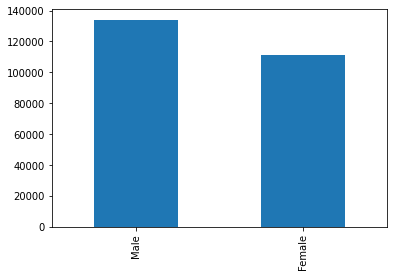

In [10]:
original_data['Gender'].value_counts().plot(kind='bar')

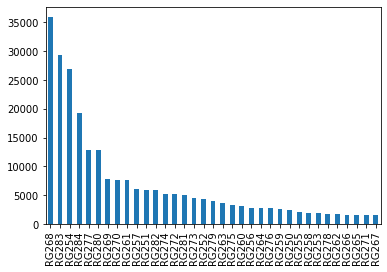

In [11]:
original_data['Region_Code'].value_counts().plot(kind='bar')

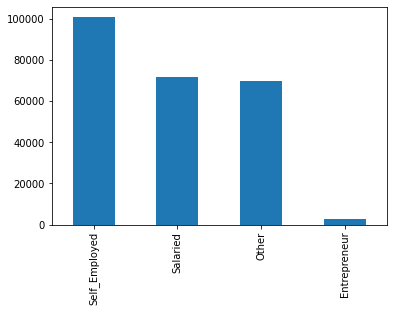

In [12]:
original_data['Occupation'].value_counts().plot(kind='bar')

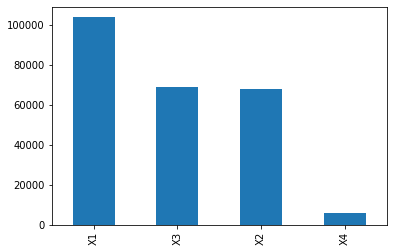

In [13]:
original_data['Channel_Code'].value_counts().plot(kind='bar')

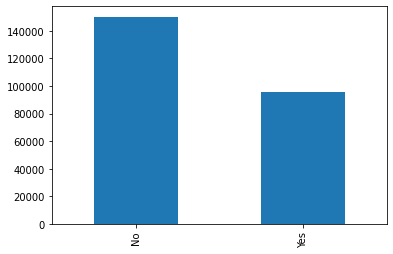

In [14]:
original_data['Is_Active'].value_counts().plot(kind='bar')

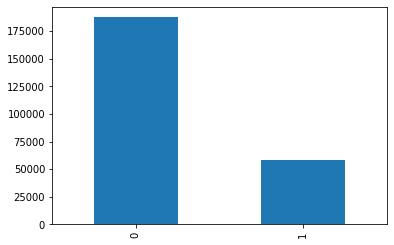

In [15]:
original_data['Is_Lead'].value_counts().plot(kind='bar')

In [16]:
print(" percentage  of Not Lead or 0 class is ", original_data['Is_Lead'].value_counts()[0] / original_data.shape[0])
print(" percentage  of Lead or 1 class is ", original_data['Is_Lead'].value_counts()[1] / original_data.shape[0])

 percentage  of Not Lead or 0 class is  0.7627917387323228
 percentage  of Lead or 1 class is  0.23720826126767727


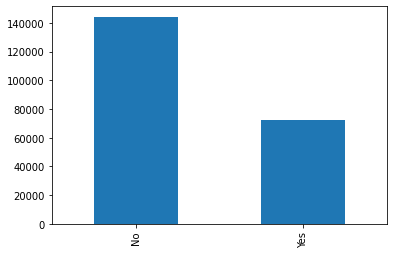

In [17]:
original_data['Credit_Product'].value_counts().plot(kind='bar')

In [18]:
# % of null values in Credit_Product feature
original_data['Credit_Product'].isnull().sum() / original_data.shape[0]

0.11934072642181301

In [19]:
original_data['Credit_Product'].value_counts()

No     144357
Yes     72043
Name: Credit_Product, dtype: int64

In [20]:
original_data['Credit_Product'].mode()

0    No
dtype: object

In [21]:
# filling null values with No as its the majority class in Credit_Product
original_data['Credit_Product'].fillna(original_data['Credit_Product'].mode()[0], inplace=True)

In [22]:
# Value counts after filling null values
original_data['Credit_Product'].value_counts()

No     173682
Yes     72043
Name: Credit_Product, dtype: int64

In [23]:
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   245725 non-null  object
 1   Gender               245725 non-null  object
 2   Age                  245725 non-null  int64 
 3   Region_Code          245725 non-null  object
 4   Occupation           245725 non-null  object
 5   Channel_Code         245725 non-null  object
 6   Vintage              245725 non-null  int64 
 7   Credit_Product       245725 non-null  object
 8   Avg_Account_Balance  245725 non-null  int64 
 9   Is_Active            245725 non-null  object
 10  Is_Lead              245725 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 20.6+ MB


In [24]:
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]], drop_first=True)
    res = pd.concat([original_dataframe, dummies], axis=1)
    return(res)

In [25]:
encode_df = encode_and_bind(original_data, 'Gender')

In [26]:
encode_df = encode_and_bind(encode_df, 'Region_Code')

In [27]:
encode_df = encode_and_bind(encode_df, 'Occupation')

In [28]:
encode_df = encode_and_bind(encode_df, 'Channel_Code')

In [29]:
encode_df = encode_and_bind(encode_df, 'Credit_Product')

In [30]:
encode_df = encode_and_bind(encode_df, 'Is_Active')

In [31]:
encode_df.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead,Gender_Male,Region_Code_RG251,Region_Code_RG252,Region_Code_RG253,Region_Code_RG254,Region_Code_RG255,Region_Code_RG256,Region_Code_RG257,Region_Code_RG258,Region_Code_RG259,Region_Code_RG260,Region_Code_RG261,Region_Code_RG262,Region_Code_RG263,Region_Code_RG264,Region_Code_RG265,Region_Code_RG266,Region_Code_RG267,Region_Code_RG268,Region_Code_RG269,Region_Code_RG270,Region_Code_RG271,Region_Code_RG272,Region_Code_RG273,Region_Code_RG274,Region_Code_RG275,Region_Code_RG276,Region_Code_RG277,Region_Code_RG278,Region_Code_RG279,Region_Code_RG280,Region_Code_RG281,Region_Code_RG282,Region_Code_RG283,Region_Code_RG284,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Credit_Product_Yes,Is_Active_Yes
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0


In [32]:
encode_df.drop(labels=['ID','Gender','Is_Active','Credit_Product','Channel_Code','Occupation','Region_Code' ], axis=1, inplace=True)

In [33]:
encode_df.head()

,Age,Vintage,Avg_Account_Balance,Is_Lead,Gender_Male,Region_Code_RG251,Region_Code_RG252,Region_Code_RG253,Region_Code_RG254,Region_Code_RG255,Region_Code_RG256,Region_Code_RG257,Region_Code_RG258,Region_Code_RG259,Region_Code_RG260,Region_Code_RG261,Region_Code_RG262,Region_Code_RG263,Region_Code_RG264,Region_Code_RG265,Region_Code_RG266,Region_Code_RG267,Region_Code_RG268,Region_Code_RG269,Region_Code_RG270,Region_Code_RG271,Region_Code_RG272,Region_Code_RG273,Region_Code_RG274,Region_Code_RG275,Region_Code_RG276,Region_Code_RG277,Region_Code_RG278,Region_Code_RG279,Region_Code_RG280,Region_Code_RG281,Region_Code_RG282,Region_Code_RG283,Region_Code_RG284,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Credit_Product_Yes,Is_Active_Yes
0,73,43,1045696,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
1,30,32,581988,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,56,26,1484315,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1
3,34,19,470454,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,30,33,886787,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0


In [34]:
X=encode_df.drop(labels=['Is_Lead'], axis=1)

In [35]:
y=encode_df['Is_Lead']

In [36]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25, random_state=2, stratify=y)

In [37]:
print('Dataset: Class0=%d, Class1=%d' % (len(y[y==0]), len(y[y==1])))
print('Train: Class0=%d, Class1=%d' % (len(y_train[y_train==0]), len(y_train[y_train==1])))
print('Test: Class0=%d, Class1=%d' % (len(y_test[y_test==0]), len(y_test[y_test==1])))

Dataset: Class0=187437, Class1=58288
Train: Class0=140577, Class1=43716
Test: Class0=46860, Class1=14572


In [38]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [39]:
X_train_scaled.shape

(184293, 46)

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

log_clf = LogisticRegression(random_state=20)
log_clf.fit(X_train_scaled, y_train)
y_pred_log_clf = log_clf.predict(X_test_scaled)
print(log_clf.__class__.__name__,   "Accuracy score is " , accuracy_score(y_test, y_pred_log_clf))
y_pred_prob_log_clf = log_clf.predict_proba(X_test_scaled)
print(log_clf.__class__.__name__, "ROC_AUC score is " , roc_auc_score(y_test, y_pred_prob_log_clf[:,1]))

LogisticRegression Accuracy score is  0.7765008464643833
LogisticRegression ROC_AUC score is  0.730707062603706


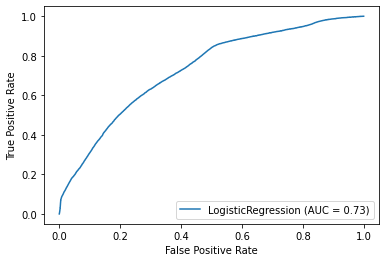

In [41]:
from sklearn.metrics import plot_roc_curve 
plot_roc_curve(log_clf, X_test_scaled, y_test)
plt.show()

In [42]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier()
rnd_clf.fit(X_train_scaled, y_train)

y_pred_rnd_clf = rnd_clf.predict(X_test_scaled)
print(rnd_clf.__class__.__name__,   "Accuracy score is " , accuracy_score(y_test, y_pred_rnd_clf))
y_pred_prob_rnd_clf = rnd_clf.predict_proba(X_test_scaled)
print(rnd_clf.__class__.__name__, "ROC_AUC score is " , roc_auc_score(y_test, y_pred_prob_rnd_clf[:,1]))

RandomForestClassifier Accuracy score is  0.7749381429873682
RandomForestClassifier ROC_AUC score is  0.749647738680898


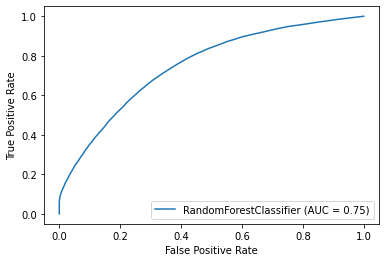

In [43]:
plot_roc_curve(rnd_clf, X_test_scaled, y_test)
plt.show()

In [44]:
from sklearn.tree import DecisionTreeClassifier

dclf=DecisionTreeClassifier()
dclf.fit(X_train_scaled,y_train)
y_pred_dclf=dclf.predict(X_test_scaled)
print(dclf.__class__.__name__,   "Accuracy score is " , accuracy_score(y_test, y_pred_dclf))
y_pred_prob_dclf = rnd_clf.predict_proba(X_test_scaled)
print(dclf.__class__.__name__, "ROC_AUC score is " , roc_auc_score(y_test, y_pred_prob_dclf[:,1]))

DecisionTreeClassifier Accuracy score is  0.7147740591222815
DecisionTreeClassifier ROC_AUC score is  0.749647738680898


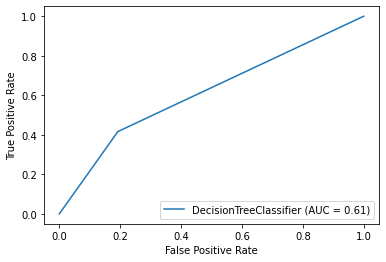

In [45]:
plot_roc_curve(dclf, X_test_scaled, y_test)
plt.show()

In [46]:
from sklearn.ensemble import BaggingClassifier

bag_dclf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1)
bag_dclf.fit(X_train_scaled, y_train)
y_pred_bag_dclf = bag_dclf.predict(X_test_scaled)
print(bag_dclf.__class__.__name__,   "Accuracy score is " , accuracy_score(y_test, y_pred_bag_dclf))
y_pred_prob_bag_dclf = bag_dclf.predict_proba(X_test_scaled)
print(bag_dclf.__class__.__name__, "ROC_AUC score is " , roc_auc_score(y_test, y_pred_prob_bag_dclf[:,1]))

BaggingClassifier Accuracy score is  0.7768101315275426
BaggingClassifier ROC_AUC score is  0.7530835663001876


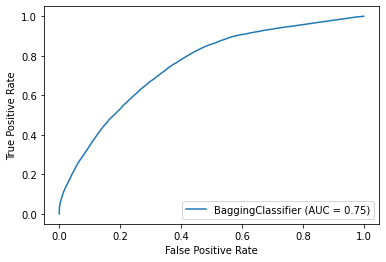

In [47]:
plot_roc_curve(bag_dclf, X_test_scaled, y_test)
plt.show()

In [48]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(random_state=20, n_jobs=-1, learning_rate=0.1, n_estimators=100, max_depth=3)
xgb_clf.fit(X_train_scaled, y_train)
y_pred_xgb_clf = xgb_clf.predict(X_test_scaled)
print(xgb_clf.__class__.__name__,   "Accuracy score is " , accuracy_score(y_test, y_pred_xgb_clf))
y_pred_prob_xgb_clf = xgb_clf.predict_proba(X_test_scaled)
print(xgb_clf.__class__.__name__, "ROC_AUC score is " , roc_auc_score(y_test, y_pred_prob_xgb_clf[:,1]))

XGBClassifier Accuracy score is  0.7903047271780179
XGBClassifier ROC_AUC score is  0.7796689014965528


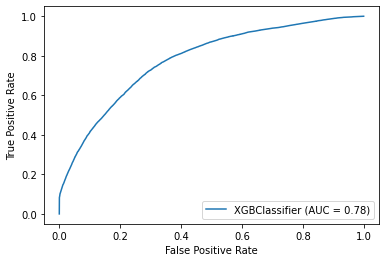

In [49]:
plot_roc_curve(xgb_clf, X_test_scaled, y_test)
plt.show()

In [52]:
random_forest = RandomForestClassifier(n_estimators=100, oob_score = True)
random_forest.fit(X_train_scaled, y_train)
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')

In [53]:
importances

,importance
feature,
Avg_Account_Balance,0.291
Vintage,0.225
Age,0.223
Occupation_Salaried,0.021
Channel_Code_X3,0.020
Channel_Code_X2,0.019
Credit_Product_Yes,0.018
Is_Active_Yes,0.018
Gender_Male,0.018


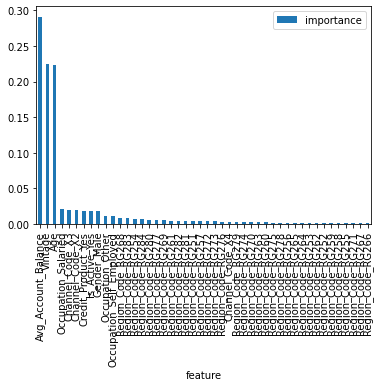

In [54]:
importances.plot.bar()

In [55]:
X_train1 = X_train.drop(labels=['Region_Code_RG276', 'Region_Code_RG279', 'Channel_Code_X4', 'Region_Code_RG270', 'Region_Code_RG263', 'Region_Code_RG260', 'Region_Code_RG274', 'Region_Code_RG275', 'Region_Code_RG255', 'Region_Code_RG256', 'Region_Code_RG258', 'Region_Code_RG259', 'Region_Code_RG262', 'Region_Code_RG264', 'Region_Code_RG265', 'Region_Code_RG252', 'Region_Code_RG278', 'Region_Code_RG253', 'Region_Code_RG266', 'Region_Code_RG267', 'Region_Code_RG271'], axis=1)

In [56]:
X_test1 = X_test.drop(labels=['Region_Code_RG276', 'Region_Code_RG279', 'Channel_Code_X4', 'Region_Code_RG270', 'Region_Code_RG263', 'Region_Code_RG260', 'Region_Code_RG274', 'Region_Code_RG275', 'Region_Code_RG255', 'Region_Code_RG256', 'Region_Code_RG258', 'Region_Code_RG259', 'Region_Code_RG262', 'Region_Code_RG264', 'Region_Code_RG265', 'Region_Code_RG252', 'Region_Code_RG278', 'Region_Code_RG253', 'Region_Code_RG266', 'Region_Code_RG267', 'Region_Code_RG271'], axis=1)

In [57]:
scaler1 = StandardScaler()
scaler1.fit(X_train1)

X_train1_scaled = scaler1.transform(X_train1)
X_test1_scaled = scaler1.transform(X_test1)

In [58]:
xgb_clf1 = XGBClassifier(random_state=20, n_jobs=-1, learning_rate=0.1, n_estimators=100, max_depth=3)
xgb_clf1.fit(X_train1_scaled, y_train)
y_pred_xgb_clf1 = xgb_clf1.predict(X_test1_scaled)
print(xgb_clf1.__class__.__name__,   "Accuracy score is " , accuracy_score(y_test, y_pred_xgb_clf1))
y_pred_prob_xgb_clf1 = xgb_clf1.predict_proba(X_test1_scaled)
print(xgb_clf1.__class__.__name__, "ROC_AUC score is " , roc_auc_score(y_test, y_pred_prob_xgb_clf1[:,1]))

XGBClassifier Accuracy score is  0.7903861179841125
XGBClassifier ROC_AUC score is  0.7788451261307269


In [ ]:
param_grid = { "criterion" : ["gini"], "min_samples_leaf" : [ 50, 70], "min_samples_split" : [18, 25, 35], "n_estimators": [100, 400, 700]}

from sklearn.model_selection import RandomizedSearchCV, cross_val_score

rf = RandomForestClassifier(max_features='auto', oob_score=True, random_state=1, n_jobs=-1)

clf = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_jobs=-1)

clf.fit(X_train1_scaled, y_train)



In [60]:
y_pred_prob_clf1 = clf.predict_proba(X_test1_scaled)
print(clf.__class__.__name__, "ROC_AUC score is " , roc_auc_score(y_test, y_pred_prob_clf1[:,1]))

RandomizedSearchCV ROC_AUC score is  0.7840420977900777


In [89]:

rnd_clf1 = RandomForestClassifier(criterion= 'gini', max_depth= 4, max_features = 'auto',max_samples= 0.3 , min_samples_leaf=800 , min_samples_split= 1000, max_leaf_nodes = 25, n_estimators= 100)
rnd_clf1.fit(X_train1_scaled, y_train)

y_pred_rnd_clf1 = rnd_clf1.predict(X_test1_scaled)
print(rnd_clf1.__class__.__name__,   "Accuracy score is " , accuracy_score(y_test, y_pred_rnd_clf1))
y_pred_prob_rnd_clf1 = rnd_clf1.predict_proba(X_test1_scaled)
print(rnd_clf1.__class__.__name__, "ROC_AUC score is " , roc_auc_score(y_test, y_pred_prob_rnd_clf1[:,1]))



RandomForestClassifier Accuracy score is  0.7657572600599036
RandomForestClassifier ROC_AUC score is  0.7559582239525542


In [ ]:
'''
%%time
from sklearn.model_selection import cross_val_score
from hyperopt import hp, tpe, fmin,STATUS_OK,Trials
def accuracy_model(params):
   clf = RandomForestClassifier(**params)
   return cross_val_score(clf, X_train1_scaled, y_train).mean()
param_space = {'max_depth': hp.choice('max_depth', range(10,100)),
'max_features': hp.uniform('max_features', 0.1,1),
'n_estimators': hp.choice('n_estimators', range(150,300)),
'min_samples_leaf': hp.choice('min_samples_leaf',range(3,5)),
'min_samples_split': hp.choice('min_samples_split',range(2,10)),
'criterion': hp.choice('criterion', ["gini", "entropy"])}
best = 0
def f(params):
    global best
    acc = accuracy_model(params)
    if acc > best:
       best = acc
    return {'loss': -acc, 'status': STATUS_OK}
Trials = Trials()
best_params = fmin(f, param_space , algo=tpe.suggest,max_evals=20, trials= Trials)
print('New best:', best, best_params)
print(best_params)
'''

In [ ]:
'''
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_scaled, y_train)
y_pred_knn_clf = xgb_clf.predict(X_test_scaled)
print(knn_clf.__class__.__name__,   "Accuracy score is " , accuracy_score(y_test, y_pred_knn_clf))
y_pred_prob_knn_clf = knn_clf.predict_proba(X_test_scaled)
print(knn_clf.__class__.__name__, "ROC_AUC score is " , roc_auc_score(y_test, y_pred_prob_knn_clf[:,1]))
'''

In [ ]:
'''
bag_xbg_clf = BaggingClassifier(
    XGBClassifier(random_state=20, n_jobs=-1, learning_rate=0.1, n_estimators=100, max_depth=4), n_estimators=500,
    max_samples=1000, bootstrap=True, n_jobs=-1)
bag_xbg_clf.fit(X_train_scaled, y_train)
y_pred_bag_xbg_clf = bag_xbg_clf.predict(X_test_scaled)
print(bag_xbg_clf.__class__.__name__,   "Accuracy score is " , accuracy_score(y_test, y_pred_bag_xbg_clf))
y_pred_prob_bag_xbg_clf = bag_xbg_clf.predict_proba(X_test_scaled)
print(bag_xbg_clf.__class__.__name__, "ROC_AUC score is " , roc_auc_score(y_test, y_pred_prob_bag_xbg_clf[:,1]))
'''

### Actual Test data

In [61]:
from google.colab import files
upload2 = files.upload()

Saving test_mSzZ8RL.csv to test_mSzZ8RL.csv


In [62]:
original_data_test = pd.read_csv(io.BytesIO(upload2['test_mSzZ8RL.csv']))

In [63]:
original_data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105312 entries, 0 to 105311
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   105312 non-null  object
 1   Gender               105312 non-null  object
 2   Age                  105312 non-null  int64 
 3   Region_Code          105312 non-null  object
 4   Occupation           105312 non-null  object
 5   Channel_Code         105312 non-null  object
 6   Vintage              105312 non-null  int64 
 7   Credit_Product       92790 non-null   object
 8   Avg_Account_Balance  105312 non-null  int64 
 9   Is_Active            105312 non-null  object
dtypes: int64(3), object(7)
memory usage: 8.0+ MB


In [64]:
original_data_test['Credit_Product'].fillna(original_data_test['Credit_Product'].mode()[0], inplace=True)

In [65]:
encode_df_test = encode_and_bind(original_data_test, 'Gender')

In [66]:
encode_df_test = encode_and_bind(encode_df_test, 'Region_Code')

In [67]:
encode_df_test = encode_and_bind(encode_df_test, 'Occupation')

In [68]:
encode_df_test = encode_and_bind(encode_df_test, 'Channel_Code')

In [69]:
encode_df_test = encode_and_bind(encode_df_test, 'Credit_Product')

In [70]:
encode_df_test = encode_and_bind(encode_df_test, 'Is_Active')

In [71]:
encode_df_test.drop(labels=['ID','Gender','Is_Active','Credit_Product','Channel_Code','Occupation','Region_Code' ], axis=1, inplace=True)

In [72]:
encode_df_test = encode_df_test.drop(labels=['Region_Code_RG276', 'Region_Code_RG279', 'Channel_Code_X4', 'Region_Code_RG270', 'Region_Code_RG263', 'Region_Code_RG260', 'Region_Code_RG274', 'Region_Code_RG275', 'Region_Code_RG255', 'Region_Code_RG256', 'Region_Code_RG258', 'Region_Code_RG259', 'Region_Code_RG262', 'Region_Code_RG264', 'Region_Code_RG265', 'Region_Code_RG252', 'Region_Code_RG278', 'Region_Code_RG253', 'Region_Code_RG266', 'Region_Code_RG267', 'Region_Code_RG271'], axis=1)

In [73]:
encode_df_test_scaled = scaler1.transform(encode_df_test)

In [74]:
encode_df_test.head()

,Age,Vintage,Avg_Account_Balance,Gender_Male,Region_Code_RG251,Region_Code_RG254,Region_Code_RG257,Region_Code_RG261,Region_Code_RG268,Region_Code_RG269,Region_Code_RG272,Region_Code_RG273,Region_Code_RG277,Region_Code_RG280,Region_Code_RG281,Region_Code_RG282,Region_Code_RG283,Region_Code_RG284,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X2,Channel_Code_X3,Credit_Product_Yes,Is_Active_Yes
0,29,25,742366,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,43,49,925537,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
2,31,14,215949,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,29,33,868070,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,29,19,657087,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [75]:
encode_df_test_scaled[0]

array([-1.0025845 , -0.68029451, -0.4534755 ,  0.9116275 , -0.15737407,
        2.85540238, -0.15990835, -0.18003693, -0.41365524, -0.18122213,
       -0.14814871, -0.1363146 , -0.23515501, -0.23434444, -0.1462634 ,
       -0.15615683, -0.36781038, -0.2923717 ,  1.57986059, -0.64196599,
       -0.83589785, -0.61560876, -0.62558181,  1.55103403, -0.79571737])

In [82]:
test_sub_rnd_clf3_30=rnd_clf1.predict(encode_df_test_scaled)

In [77]:
test_sub_rnd_clf3_30

array([0, 0, 0, ..., 0, 0, 0])

In [83]:
from google.colab import files
pd.DataFrame(test_sub_rnd_clf3_30).to_csv('test_sub_rnd_clf3_30.csv') 
files.download('test_sub_rnd_clf3_30.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>